In [12]:
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
import random
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
import math
from keras.callbacks import TensorBoard

In [3]:
############################################  creating variations in datasets  ##################################################

def flippingTrainingDataset(trainingData):
    df1 = trainingData.copy()
    df2 = trainingData.copy()
    print('training dataset')
    for row in df1:
        for pixelIndex in range(len(row)):
            count = math.ceil(0.03* len(row))
            flipPixel = random.sample(range(0, len(row)),count)
            row[pixelIndex][flipPixel[0]] = 1 - row[pixelIndex][flipPixel[0]]
    for row in df2:
        for pixelIndex in range(len(row)):
            count = math.ceil(0.03* len(row))
            flipPixel = random.sample(range(0, len(row)),count)
            row[pixelIndex][flipPixel[0]] = 1 - row[pixelIndex][flipPixel[0]]
    
    return np.vstack((df1, df2)), np.vstack((trainingData, trainingData))

def flippingTestingDataset(testData):
    df1 = testData.copy()
    print('testing dataset')
    for row in df1:
        for pixelIndex in range(len(row)):
            count = math.ceil(0.03* len(row))
            flipPixel = random.sample(range(0, len(row)),count)
            row[pixelIndex][flipPixel[0]] = 1 - row[pixelIndex][flipPixel[0]] 
    return df1

In [4]:
##################################################  Loading and Transforming Data  ##############################################

(X_Train, _), (X_Test, _) = mnist.load_data()

X_Train = X_Train.astype('float32') / 255.
X_Test = X_Test.astype('float32') / 255.

flipped_X_Train, X_Train = flippingTrainingDataset(X_Train)
flipped_X_Test = flippingTestingDataset(X_Test)

X_Train = np.reshape(X_Train, (len(X_Train), 28, 28, 1))
X_Test = np.reshape(X_Test, (len(X_Test), 28, 28, 1))
flipped_X_Train = np.reshape(flipped_X_Train, (len(flipped_X_Train), 28, 28, 1))
flipped_X_Test = np.reshape(flipped_X_Test, (len(flipped_X_Test), 28, 28, 1))

print('Done')

training dataset
testing dataset
Done


In [5]:
###########################################  CNN 1 creation, reconstruction & plotting  #########################################

In [14]:
##################################################  CNN 1 Creation  #############################################################

input_image = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# representation now is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder1 = Model(input_image, decoded)
autoencoder1.compile(optimizer='adadelta', loss='mean_squared_logarithmic_error', metrics = ['accuracy', 'mse'])

print('Done')

Done


In [15]:
#################################################  CNN 1 History  ###############################################################

history = autoencoder1.fit(flipped_X_Train, X_Train,
                epochs=4, batch_size=512, shuffle=True,
                validation_data=(flipped_X_Test, X_Test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder1')])
print('Done')

Train on 120000 samples, validate on 10000 samples
Epoch 1/4
120000/120000 [==============================] - 406s - loss: 0.0576 - acc: 0.7987 - mean_squared_error: 0.1091 - val_loss: 0.0499 - val_acc: 0.8072 - val_mean_squared_error: 0.0988

original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped


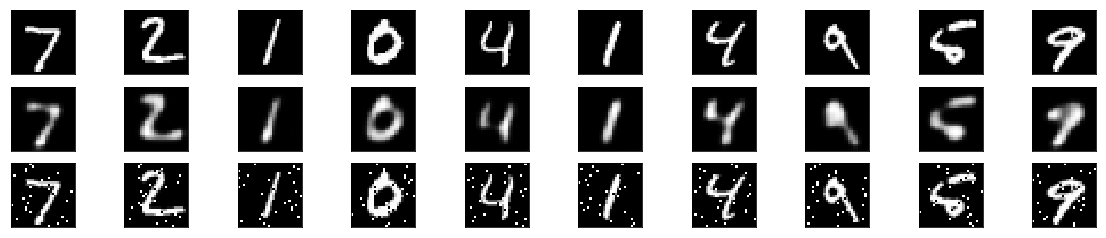

In [16]:
###################################################  Reconstructing Images  #####################################################

decoded_images = autoencoder1.predict(flipped_X_Test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    print ("original")
    ax = plt.subplot(3, n, i)
    plt.imshow(X_Test[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    print ("Reconstructed")
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_images[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display flipped
    print ("Flipped")
    ax = plt.subplot(3, n, i+ (2*n))
    plt.imshow(flipped_X_Test[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

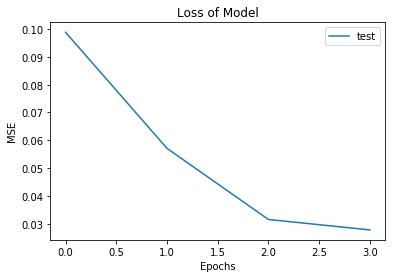

Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits


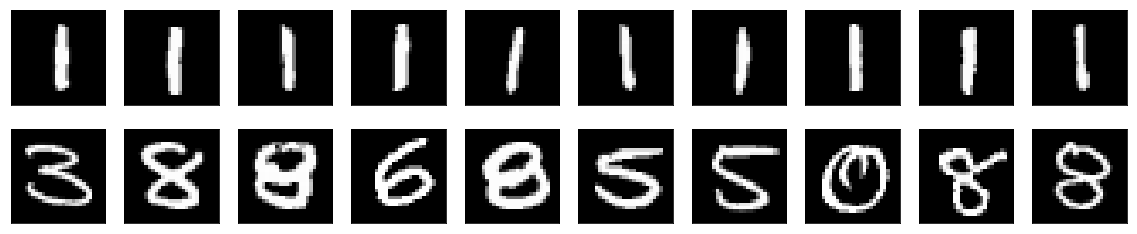

In [17]:
#############################################  Plotting Error & Best - Worst Digits  ############################################

plt.plot(history.history['val_mean_squared_error'])
plt.title('Loss of Model')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['test'], loc='upper right')
plt.show()

#Calculating mse per test image
errors = []
indices = []

for i in range(0, 10000):
    pred = np.reshape(decoded_images[i], (1, 784))
    true = np.reshape(X_Test[i], (1, 784))
    errors.append(float(euclidean_distances(pred, true)))
    indices.append(i)
    
errors, indices = zip(*sorted(zip(errors, indices)))
    
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    print ("Best Digits")
    ax = plt.subplot(2, n, i)
    plt.imshow(X_Test[indices[i-1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #reconstructed
    print ("Worst Digits")
    ax = plt.subplot(2, n, i+n)
    plt.imshow(X_Test[indices[9999-i-1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
############################################  CNN 2 creation, reconstruction & plotting  ########################################

In [19]:
##################################################  CNN 2 Creation  #############################################################

input_image = Input(shape=(28, 28, 1))

x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_image)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# representation now is (7, 7, 32)

x = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder2 = Model(input_image, decoded)
autoencoder2.compile(optimizer='adadelta', loss='binary_crossentropy', metrics = ['accuracy', 'mse'])

print('Done')

Done


In [21]:
#################################################  CNN 2 History  ###############################################################

history = autoencoder2.fit(flipped_X_Train, X_Train,
                epochs=4, batch_size=512, shuffle=True,
                validation_data=(flipped_X_Test, X_Test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder2')])
print('Done')

Train on 120000 samples, validate on 10000 samples
Epoch 1/4
120000/120000 [==============================] - 1136s - loss: 0.0991 - acc: 0.8130 - mean_squared_error: 0.0121 - val_loss: 0.0920 - val_acc: 0.8122 - val_mean_squared_error: 0.0100

original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped
original
Reconstructed
Flipped


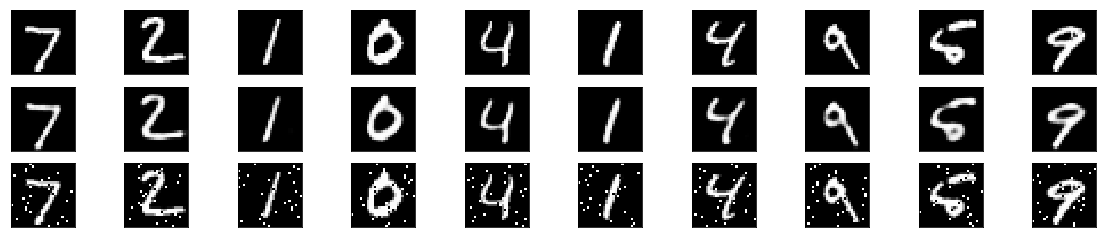

In [22]:
###################################################  Reconstructing Images  #####################################################

decoded_images = autoencoder2.predict(flipped_X_Test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    print ("original")
    ax = plt.subplot(3, n, i)
    plt.imshow(X_Test[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    print ("Reconstructed")
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_images[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display flipped
    print ("Flipped")
    ax = plt.subplot(3, n, i+ (2*n))
    plt.imshow(flipped_X_Test[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

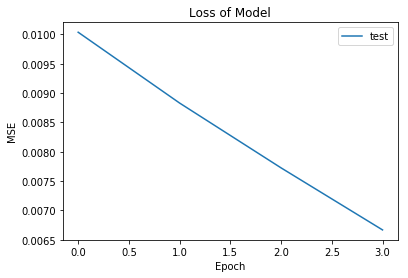

Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits


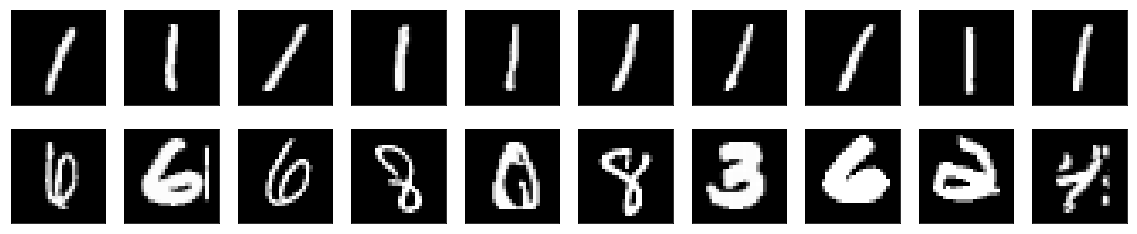

In [23]:
#############################################  Plotting Error & Best - Worst Digits  ############################################

plt.plot(history.history['val_mean_squared_error'])
plt.title('Loss of Model')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['test'], loc='upper right')
plt.show()

#Calculating mse per test image
errors = []
indices = []

for i in range(0, 10000):
    pred = np.reshape(decoded_images[i], (1, 784))
    true = np.reshape(X_Test[i], (1, 784))
    errors.append(float(euclidean_distances(pred, true)))
    indices.append(i)

errors, indices = zip(*sorted(zip(errors, indices)))
    
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    print ("Best Digits")
    ax = plt.subplot(2, n, i)
    plt.imshow(X_Test[indices[i-1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #reconstructed
    print ("Worst Digits")
    ax = plt.subplot(2, n, i+n)
    plt.imshow(X_Test[indices[9999-i-1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
############################################  CNN 3 creation, reconstruction & plotting  ########################################

In [24]:
##################################################  CNN 3 Creation  #############################################################

input_image = Input(shape=(28, 28, 1))

x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_image)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# representation now is (7, 7, 32)

x = Conv2D(32, (5, 5), activation='sigmoid', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='sigmoid', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)

autoencoder3 = Model(input_image, decoded)
autoencoder3.compile(optimizer='adadelta', loss='mean_squared_logarithmic_error', metrics = ['accuracy', 'mse'])

print('Done')

Done


In [25]:
#################################################  CNN 3 History  ###############################################################

history = autoencoder3.fit(flipped_X_Train, X_Train,
                epochs=3, batch_size=512, shuffle=True,
                validation_data=(flipped_X_Test, X_Test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder3')])
print('Done')

Train on 120000 samples, validate on 10000 samples
Epoch 1/3
120000/120000 [==============================] - 2700s - loss: 0.0493 - acc: 0.8054 - mean_squared_error: 0.0956 - val_loss: 0.0353 - val_acc: 0.8072 - val_mean_squared_error: 0.0693

Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped


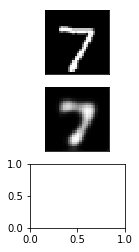

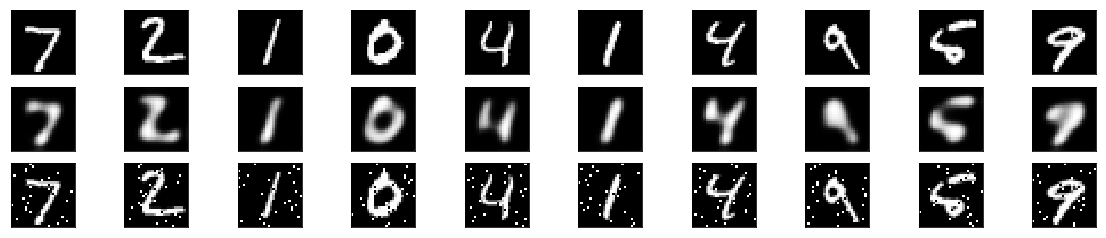

In [27]:
###################################################  Reconstructing Images  #####################################################

decoded_images = autoencoder3.predict(flipped_X_Test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    print ("Original")
    ax = plt.subplot(3, n, i)
    plt.imshow(X_Test[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    print ("Reconstructed")
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_images[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display flipped
    print ("Flipped")
    ax = plt.subplot(3, n, i+ (2*n))
    plt.imshow(flipped_X_Test[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

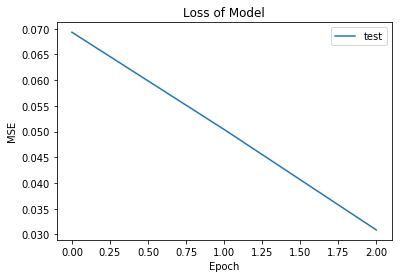

Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits


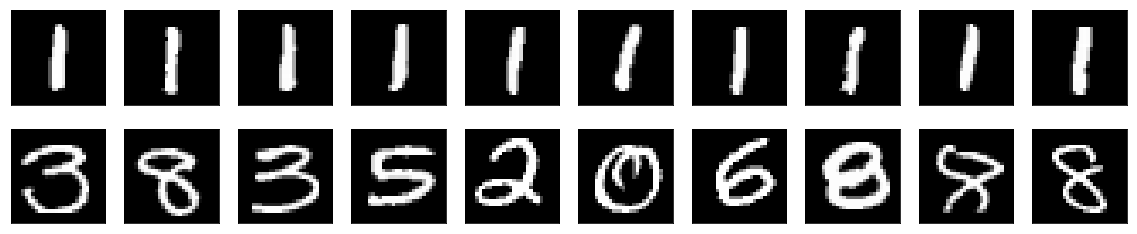

In [28]:
#############################################  Plotting Error & Best - Worst Digits  ############################################

plt.plot(history.history['val_mean_squared_error'])
plt.title('Loss of Model')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['test'], loc='upper right')
plt.show()

#Calculating mse per test image
errors = []
indices = []

for i in range(0, 10000):
    pred = np.reshape(decoded_images[i], (1, 784))
    true = np.reshape(X_Test[i], (1, 784))
    errors.append(float(euclidean_distances(pred, true)))
    indices.append(i)

errors, indices = zip(*sorted(zip(errors, indices)))
    
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    print ("Best Digits")
    ax = plt.subplot(2, n, i)
    plt.imshow(X_Test[indices[i-1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #reconstructed
    print ("Worst Digits")
    ax = plt.subplot(2, n, i+n)
    plt.imshow(X_Test[indices[9999-i-1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
############################################  CNN 4 creation, reconstruction & plotting  ########################################

In [29]:
##################################################  CNN 4 Creation  #############################################################

input_image = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# representation now is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder4 = Model(input_image, decoded)
autoencoder4.compile(optimizer='adadelta', loss='binary_crossentropy', metrics = ['accuracy', 'mse'])

print('Done')

Done


In [30]:
#################################################  CNN 4 History  ###############################################################

history = autoencoder4.fit(flipped_X_Train, X_Train,
                epochs=5, batch_size=512, shuffle=True,
                validation_data=(flipped_X_Test, X_Test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder4')])
print('Done')

Train on 120000 samples, validate on 10000 samples
Epoch 1/5
120000/120000 [==============================] - 503s - loss: 0.2049 - acc: 0.8027 - mean_squared_error: 0.0468 - val_loss: 0.1198 - val_acc: 0.8051 - val_mean_squared_error: 0.0194

Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped
Original
Reconstructed
Flipped


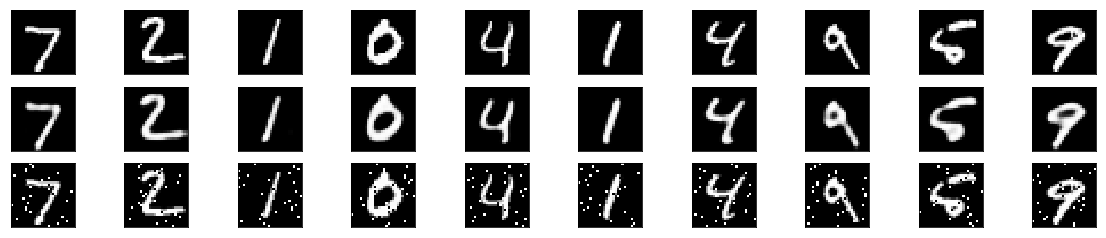

In [31]:
###################################################  Reconstructing Images  #####################################################

decoded_images = autoencoder4.predict(flipped_X_Test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    print ("Original")
    ax = plt.subplot(3, n, i)
    plt.imshow(X_Test[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    print ("Reconstructed")
    ax = plt.subplot(3, n, i + n)
    plt.imshow(decoded_images[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display flipped
    print ("Flipped")
    ax = plt.subplot(3, n, i+ (2*n))
    plt.imshow(flipped_X_Test[i-1].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

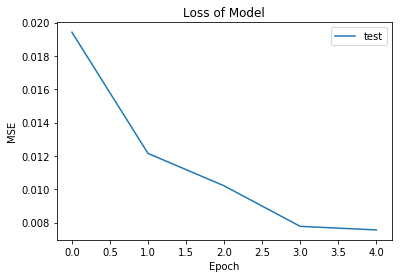

Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits
Best Digits
Worst Digits


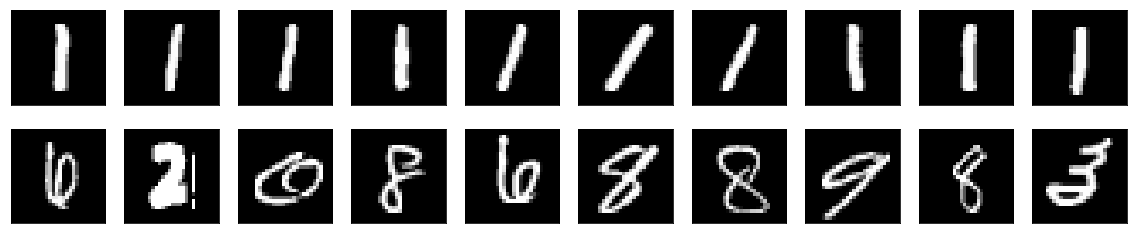

In [32]:
#############################################  Plotting Error & Best - Worst Digits  ############################################

plt.plot(history.history['val_mean_squared_error'])
plt.title('Loss of Model')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['test'], loc='upper right')
plt.show()

#Calculating mse per test image
errors = []
indices = []

for i in range(0, 10000):
    pred = np.reshape(decoded_images[i], (1, 784))
    true = np.reshape(X_Test[i], (1, 784))
    errors.append(float(euclidean_distances(pred, true)))
    indices.append(i)

errors, indices = zip(*sorted(zip(errors, indices)))
    
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    print ("Best Digits")
    ax = plt.subplot(2, n, i)
    plt.imshow(X_Test[indices[i-1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #reconstructed
    print ("Worst Digits")
    ax = plt.subplot(2, n, i+n)
    plt.imshow(X_Test[indices[9999-i-1]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

REPORT

This part of the assignment deals with the MNIST dataset. A modified training set is then created by flipping 3% of the pixels in the image. This is done to add noise to the dataset. A convolutional neural network (CNN) is then created in 4 different ways to provide the best possible optimization.

CNN 1
- 2 convolutional and 1 max pooling layer with 32 filters of size 3 x 3 is used with the 'relu' activation for encoding the images. The final representation is a 7 x 7 x 32 image
- 3 convolutional and 2 up sampling layers with 32 filters of size 3 x 3 are used with 'sigmoid' activation for decoding the images.
- The autoencoder uses adadelta optimizer and mean_squares_logarithmic_error loss function.
After a training of 4 epochs, an accuracy of 80.92% and rmse of 0.0278 is achieved which is quite good. Visually the reconstructed images are quite discernable and the CNN performs well. The best digit is '1' and the worst digits are '3', '6', '5' and '8'.

CNN 2
- 2 convolutional and 1 max pooling layer with 32 filters of size 5 x 5 is used with the 'relu' activation for encoding the images. The final representation is a 7 x 7 x 32 image
- 3 convolutional and 2 up sampling layers with 32 filters of size 5 x 5 are used with 'relu' and 'sigmoid' activation for decoding the images.
- The autoencoder uses adadelta optimizer and binary_crossentropy loss function.
After a training of 4 epochs, an accuracy of 81.04% and rmse of 0.0067 is achieved. The best digit is '1' and the worst are ''6', '8' and '3'. With an increase in the filter size using the same loss function of 'binary_crossentropy', the rmse increases. This is because, since the image size is itself very small, an increase in filter size will cause the CNN to smoothen more part of the image and this is not good.

CNN 3
- 2 convolutional and 1 max pooling layer with 32 filters of size 5 x 5 is used with the 'relu' activation for encoding the images. The final representation is a 7 x 7 x 32 image
- 3 convolutional and 2 up sampling layers with 32 filters of size 5 x 5 are used with 'sigmoid' activation for decoding the images.
- The autoencoder uses adadelta optimizer and mean_squared_logarithmic_error loss function.
After a training of 3 epochs, an accuracy of 80.09% and rmse of 0.03 is achieved. The best digit is '1' and the worst is '5' and '8' and '3'. With an increase in the filter size using the same loss function of 'mean_squared_logarithmic_error', the rmse increases. This is because, since the image size is itself very small, an increase in filter size will cause the CNN to smoothen more part of the image and this is not good. 

CNN 4
- 2 convolutional and 1 max pooling layer with 32 filters of size 3 x 3 is used with the 'relu' activation for encoding the images. The final representation is a 7 x 7 x 32 image
- 3 convolutional and 2 up sampling layers with 32 filters of size 3 x 3 are used with 'relu' and 'sigmoid' activation for decoding the images.
- The autoencoder uses adadelta optimizer and binary_crossentropy loss function.
After a training of 5 epochs, an accuracy of 81.31% and rmse of 0.0076 is achieved. The best digit is '1' and the worst is '2', '6' and '8'. With a decrease in the filter size using the same loss function of 'binary_crossentropy', the rmse decreases. This is because, since the image size is itself very small, a decrease in filter size will cause the CNN to smoothen lesser part of the image and this is better.